In [2]:
import os
import time
import requests
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection
import copy
import pickle
import itertools

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18

from tqdm.notebook import tqdm

from glob import glob
from collections import defaultdict

import importlib

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
RNG = torch.Generator().manual_seed(42)

Running on device: CPU


In [3]:
# import custom libraries

from utils import preprocess, dataset, network, train, report
importlib.reload(preprocess)
importlib.reload(dataset)
importlib.reload(network)
importlib.reload(train)
importlib.reload(report)

<module 'utils.report' from '/Users/d9sus4/Documents/research projects/EHR-Distillation/utils/report.py'>

In [4]:
# compute (or load from saved pickel) data statistics

LOAD_FROM_SAVED = True
STAT_PKL_DIR = "./saved_data/stats/"
if not os.path.exists(STAT_PKL_DIR):
    os.makedirs(STAT_PKL_DIR)

CATEGORICAL_NUM_CLS_DICT = {  # how many classes are there for categorical classes
    "capillary_refill_rate": 2,
    "glascow_coma_scale_eye_opening": 4,
    "glascow_coma_scale_motor_response": 6,
    "glascow_coma_scale_total": 13,
    "glascow_coma_scale_verbal_response": 5,
}

stat_pkl_path = os.path.join(STAT_PKL_DIR, "ihm_preliminary.pkl")
if os.path.exists(stat_pkl_path) and LOAD_FROM_SAVED:
    with open(stat_pkl_path, 'rb') as f:
        continuous_avgs_train, continuous_stds_train, categorical_modes_train = pickle.load(f)
else: # compute and save
    continuous_avgs_train, continuous_stds_train, categorical_modes_train =  preprocess.compute_feature_statistics(
        ts_dir="./data/mimic3/benchmark/in-hospital-mortality/train/",
        feature_dict=preprocess.mimic3_benchmark_variable_dict
        )
    with open(stat_pkl_path, 'wb') as f:
        pickle.dump((continuous_avgs_train, continuous_stds_train, categorical_modes_train), f)


In [14]:
# define ihm objective datasets and dataloaders

ihm_num_cls = 2 # this is a binary classification objective

IHM_BALANCE = False
IHM_MASK = False

LOAD_TO_RAM = True

ihm_train_set = dataset.IHMPreliminaryDatasetReal(
    dir="./data/mimic3/ihm_preliminary/train/",
    dstype="train",
    avg_dict=continuous_avgs_train,
    std_dict=continuous_stds_train,
    numcls_dict=CATEGORICAL_NUM_CLS_DICT,
    balance=IHM_BALANCE,
    mask=IHM_MASK,
    load_to_ram=LOAD_TO_RAM,
    )
print(f"First item in the dataset: \n{ihm_train_set[0]}")
print(f"Feature tensor shape: {ihm_train_set[0][0].shape}")

ihm_test_set = dataset.IHMPreliminaryDatasetReal(
    dir="./data/mimic3/ihm_preliminary/test/",
    dstype="test",
    avg_dict=continuous_avgs_train,
    std_dict=continuous_stds_train,
    numcls_dict=CATEGORICAL_NUM_CLS_DICT,
    balance=IHM_BALANCE,
    mask=IHM_MASK,
    load_to_ram=LOAD_TO_RAM,
    )
print(f"First item in the dataset: \n{ihm_test_set[0]}")
print(f"Feature tensor shape: {ihm_test_set[0][0].shape}")

ihm_feat_shape = ihm_train_set[0][0].shape
print(f"Input tensor shape: {ihm_feat_shape}")

# prepare dataloaders

NUM_WORKERS = 8 if not LOAD_TO_RAM else 0
IHM_BATCH_SIZE = 256

ihm_train_loader = DataLoader(ihm_train_set, IHM_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
ihm_test_loader = DataLoader(ihm_test_set, IHM_BATCH_SIZE, num_workers=NUM_WORKERS)

Joining timeseries episodes with label...
Loading dataset to RAM...
Found unified episodes file at ./data/mimic3/ihm_preliminary/train/all_episodes.pkl, skipping individuals...
First item in the dataset: 
(tensor([[ 1.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00, -3.8303e-16],
        [ 1.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00, -3.8303e-16],
        [ 1.0000e+00,  0.0000e+00,  3.9972e-02,  ...,  5.6418e-02,
          1.4145e+00,  4.7770e-02],
        ...,
        [ 1.0000e+00,  0.0000e+00,  2.6577e-02,  ...,  8.5097e-02,
          1.4145e+00,  9.9521e-02],
        [ 1.0000e+00,  0.0000e+00,  1.0695e-01,  ..., -1.8149e-02,
          1.4145e+00,  9.9521e-02],
        [ 1.0000e+00,  0.0000e+00,  2.2111e-02,  ..., -1.8149e-02,
          1.4145e+00,  9.9521e-02]]), tensor(0))
Feature tensor shape: torch.Size([48, 42])
Joining timeseries episodes with label...
Loading dataset to RAM...
Found unified episodes file at ./data/m

In [19]:
OBJECTIVE = ["ihm"][0]

if OBJECTIVE == "ihm":
    train_set = ihm_train_set
    test_set = ihm_test_set
    num_cls = ihm_num_cls
    feat_shape = ihm_feat_shape
    train_set = ihm_train_set
    test_set = ihm_test_set
    train_loader = ihm_train_loader
    test_loader = ihm_test_loader
    net_name = "1dcnn"
    continuous_avgs_train, continuous_stds_train, categorical_modes_train = continuous_avgs_train, continuous_stds_train, categorical_modes_train
    comment = ""
    train_it = 1000
    lr = 1e-2
else:
    raise NotImplementedError()

In [25]:
# get the coreset

CORESET = ["random", ][0]
# define num sampled datapoints
NPC = 1

CORESET_BATCH_SIZE = 256

feats = []
labs = []
for cls in range(num_cls):
    feat, lab = train_set.random_sample_from_class(n_samples=NPC, cls=cls, no_duplicate=True, return_as_tensor=True)
    feats.append(feat)
    labs.append(lab)
feats = torch.cat(feats, dim=0).to(DEVICE)
labs = torch.cat(labs, dim=0).to(DEVICE)
coreset = dataset.TensorDataset(feats, labs)
print(f"Coreset size = {len(coreset)}")
coreset_loader = DataLoader(coreset, batch_size=CORESET_BATCH_SIZE)

Coreset size = 2


In [18]:
# define get_net

def get_net(name, feat_shape):
    if name == "1dcnn":
        net = network.IHMPreliminary1DCNN(input_shape=feat_shape)
    elif name == "mlp":
        net = network.IHMPreliminaryMLP(input_shape=feat_shape)
    else:
        raise NotImplementedError()
    return net

Before training:


Evaluating random sampled model...:   0%|          | 0/4 [00:00<?, ?it/s]

Eval score (train): 0.5265
Eval score (test): 0.5468


Training model on coreset...:   0%|          | 0/4 [00:00<?, ?it/s]

It:   0%|          | 0/1000 [00:00<?, ?it/s]

It:   0%|          | 0/1000 [00:00<?, ?it/s]

It:   0%|          | 0/1000 [00:00<?, ?it/s]

It:   0%|          | 0/1000 [00:00<?, ?it/s]

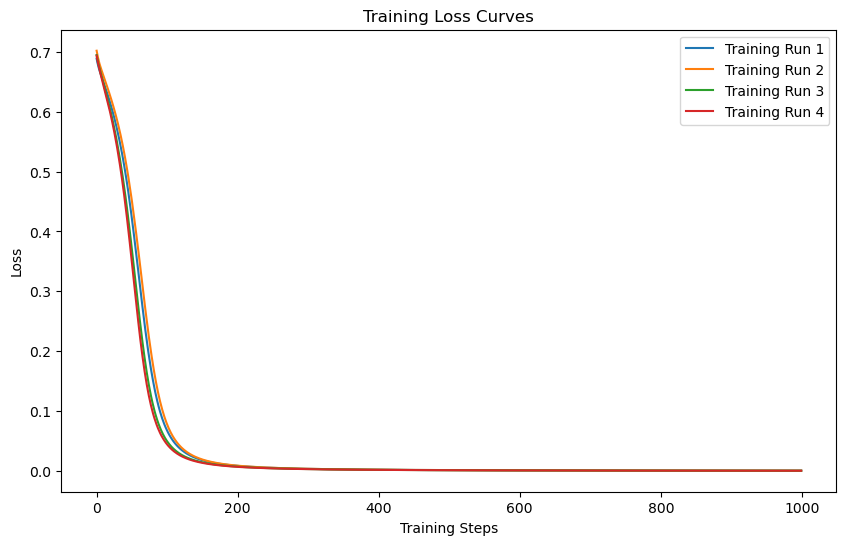

After training:


Evaluating random sampled model...:   0%|          | 0/4 [00:00<?, ?it/s]

Eval score (train): 0.6154
Eval score (test): 0.6015


In [26]:
# train and evaluate model on coreset

# evaluate distilled dataset on both training set and test set

NUM_SAMPLED_NETS_EVAL = 4

# sample a batch of models to eval on
sampled_nets = []
loss_fn = torch.nn.CrossEntropyLoss()
for j in range(NUM_SAMPLED_NETS_EVAL):
    net = get_net(net_name, feat_shape=feat_shape).to(DEVICE)
    sampled_nets.append(net)

# eval the sampled models without any training
train_scores = []
test_scores = []
print("Before training:")
pbar = tqdm(sampled_nets, desc="Evaluating random sampled model...")
for net in pbar:
    # evaluate the models on both full train set and test set before training
    train_score = report.compute_roc_auc_score(net, train_loader)
    test_score = report.compute_roc_auc_score(net, test_loader)
    train_scores.append(train_score)
    test_scores.append(test_score)
print(f"Eval score (train): {sum(train_scores) / len(train_scores):.4f}")
print(f"Eval score (test): {sum(test_scores) / len(test_scores):.4f}")

# train the models and plot curves (if exist)
train_loss_curves = []
pbar = tqdm(sampled_nets, desc="Training model on coreset...")
for net in pbar:
    train_losses = []
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    subpbar = tqdm(range(train_it), desc="It")
    for s in subpbar:
        loss, _ = train.epoch(mode="train", dataloader=coreset_loader, net=net, criterion=loss_fn, optimizer=optimizer, device=DEVICE)
        train_losses.append(loss)
    train_loss_curves.append(train_losses)
plt.figure(figsize=(10, 6))
# Iterate over each set of loss values and plot them
for i, losses in enumerate(train_loss_curves):
    plt.plot(losses, label=f'Training Run {i+1}')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss Curves')
plt.legend()
plt.show()

# eval the trained result models
train_scores = []
test_scores = []
print("After training:")
pbar = tqdm(sampled_nets, desc="Evaluating random sampled model...")
for net in pbar:
    # evaluate the models on both full train set and test set after training
    train_score = report.compute_roc_auc_score(net, train_loader)
    test_score = report.compute_roc_auc_score(net, test_loader)
    train_scores.append(train_score)
    test_scores.append(test_score)
print(f"Eval score (train): {sum(train_scores) / len(train_scores):.4f}")
print(f"Eval score (test): {sum(test_scores) / len(test_scores):.4f}")
